## Load Relevant Packages

In [69]:
#Load Relevant Packages
import numpy as np 
import pandas as pd
from pandas import DataFrame
import yfinance as yf
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import preprocessing
from pandas_datareader import data as pdr
import warnings
import ta
from ta import add_all_ta_features
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
sns.set()

%matplotlib inline

## Load and Prepare Data

In [70]:
#Load Data - Apple Stock Price Data
aapl = pdr.get_data_yahoo(["AAPL"], start='2000-01-01', end="2020-01-01")

In [71]:
data = aapl.copy()
data.columns = data.columns.droplevel(level=1) #Drop a level in the data frame

In [72]:
#Add a Column for Log returns
log_difference = np.log(data['Adj Close']).diff()
data['Log Return'] = log_difference #Set a new column for Log Returns
data = data.dropna()

In [73]:
data.head()

Attributes,Adj Close,Close,High,Low,Open,Volume,Log Return
Date,,,,,,,
2000-01-04,3.169071,3.660714,3.950893,3.613839,3.866071,128094400.0,-0.088078
2000-01-05,3.215448,3.714286,3.948661,3.678571,3.705357,194580400.0,0.014528
2000-01-06,2.937188,3.392857,3.821429,3.392857,3.790179,191993200.0,-0.090514
2000-01-07,3.076317,3.553571,3.607143,3.410714,3.446429,115183600.0,0.046280
2000-01-10,3.022212,3.491071,3.651786,3.383929,3.642857,126266000.0,-0.017744


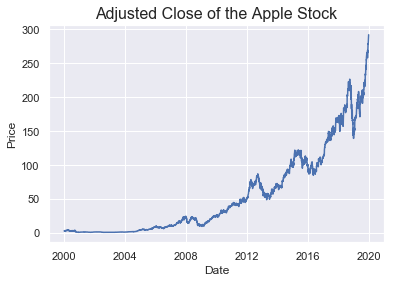

In [74]:
#Plot the Adjusted Close of the Stock
plt.title('Adjusted Close of the Apple Stock', size=16)
plt.plot(data['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

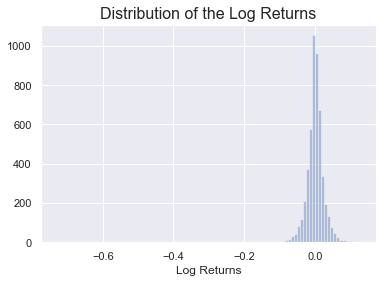

In [75]:
#Distribution of log Prices
sns.distplot(data['Log Return'], bins=100, kde=False)
plt.xlabel('Log Returns')
plt.title('Distribution of the Log Returns', size=16)
plt.show()

In [76]:
data['Datetime'] = pd.to_datetime(data.index,format='%d-%m-%Y')

In [77]:
data.head()

Attributes,Adj Close,Close,High,Low,Open,Volume,Log Return,Datetime
Date,,,,,,,,
2000-01-04,3.169071,3.660714,3.950893,3.613839,3.866071,128094400.0,-0.088078,2000-01-04
2000-01-05,3.215448,3.714286,3.948661,3.678571,3.705357,194580400.0,0.014528,2000-01-05
2000-01-06,2.937188,3.392857,3.821429,3.392857,3.790179,191993200.0,-0.090514,2000-01-06
2000-01-07,3.076317,3.553571,3.607143,3.410714,3.446429,115183600.0,0.046280,2000-01-07
2000-01-10,3.022212,3.491071,3.651786,3.383929,3.642857,126266000.0,-0.017744,2000-01-10


## Feature Engineering

### Legend for Features

In [78]:
#features_legend

Date_Related = {'f01':'Year','f02':'Month','f03':'Day',
                'f04':'Day of Week','f05':'Quarter of Year'}
Lag_Features = {'f06': 'Lag of 1 Day', 'f07':'Lag of 2 Days',
                                    'f08': 'Lag of 7 Days', 'f09': 'Lag of 30 Days'}
Rolling_Window = {'f10':'10 Day SMA','f11':'20 Day SMA',
                                     'f12':'40 Day SMA','f13':'80 Day SMA',
                                     'f14':'10 Day EWMA','f15':'20 Day EWMA',
                                     'f16':'40 Day EWMA','f17':'80 Day EWMA'}
Expanding_Window = {f'18':'10 Day Ex Win MA','f19':'20 Day Ex Win MA',
                                     'f20':'40 Day Ex Win MA','f21':'80 Day Ex Win MA'}
Technical_Indicators = {'f22': 'Volume Average Weighted Price', 'f23':'Volume Price Trend',
                                           'f24':'Average True Range','f25':'Average Directional Index',
                                           'f26':'Detrended Price Oscillator','f27':'Relative Strength Index',
                                           'f28':'Rate of Change', 'f29':'Awesome Oscillator'}

In [79]:
Date_Related = DataFrame(Date_Related.items(), columns=['Feature', 'Name'])
Lag_Features = DataFrame(Lag_Features.items(), columns=['Feature', 'Name'])
Rolling_Window = DataFrame(Rolling_Window.items(), columns=['Feature', 'Name'])
Expanding_Window = DataFrame(Expanding_Window.items(), columns=['Feature', 'Name'])
Technical_Indicators = DataFrame(Technical_Indicators.items(), columns=['Feature', 'Name'])

In [80]:
Date_Related

,Feature,Name
0,f01,Year
1,f02,Month
2,f03,Day
3,f04,Day of Week
4,f05,Quarter of Year


In [81]:
Lag_Features

,Feature,Name
0,f06,Lag of 1 Day
1,f07,Lag of 2 Days
2,f08,Lag of 7 Days
3,f09,Lag of 30 Days


In [82]:
Rolling_Window 

,Feature,Name
0,f10,10 Day SMA
1,f11,20 Day SMA
2,f12,40 Day SMA
3,f13,80 Day SMA
4,f14,10 Day EWMA
5,f15,20 Day EWMA
6,f16,40 Day EWMA
7,f17,80 Day EWMA


In [83]:
Expanding_Window 

,Feature,Name
0,18,10 Day Ex Win MA
1,f19,20 Day Ex Win MA
2,f20,40 Day Ex Win MA
3,f21,80 Day Ex Win MA


In [84]:
Technical_Indicators

,Feature,Name
0,f22,Volume Average Weighted Price
1,f23,Volume Price Trend
2,f24,Average True Range
3,f25,Average Directional Index
4,f26,Detrended Price Oscillator
5,f27,Relative Strength Index
6,f28,Rate of Change
7,f29,Awesome Oscillator


### Date Related Features

In [85]:
#Create a DataFrame for features
features = DataFrame(index = data.index)

In [86]:
#Date Related Features
"""
f01: Year
f02: Month
f03: Day
f04: Day of Week
f05: Quarter of the Year
"""
features['f01'] = data['Datetime'].dt.year
features['f02'] = data['Datetime'].dt.month
features['f03'] = data['Datetime'].dt.day
features['f04'] = data['Datetime'].dt.dayofweek
features['f05'] = data['Datetime'].dt.quarter

### Lag Features

In [87]:
"""
f06: Lag of 1 day
f07: Lag of 2 days
f08: Lag of 7 Days
f09: Lag of 30 Days
"""

features['f06'] = data['Adj Close'].shift(1)
features['f07'] = data['Adj Close'].shift(2)
features['f08'] = data['Adj Close'].shift(7)
features['f09'] = data['Adj Close'].shift(30)

### Rolling Window features

In [88]:
"""
f10: 10 Day SMA
f11: 20 Day SMA
f12: 40 Day SMA
f13: 80 Day SMA

f14: 10 Day EWMA
f15: 20 Day EWMA
f16: 40 Day EWMA
f17: 80 Day EWMA

"""

features['f10'] = data['Adj Close'].rolling(window=10).mean()
features['f11'] = data['Adj Close'].rolling(window=20).mean()
features['f12'] = data['Adj Close'].rolling(window=40).mean()
features['f13'] = data['Adj Close'].rolling(window=80).mean()

features['f14'] = data['Adj Close'].ewm(span=10, adjust=False).mean()
features['f15'] = data['Adj Close'].ewm(span=20, adjust=False).mean()
features['f16'] = data['Adj Close'].ewm(span=40, adjust=False).mean()
features['f17'] = data['Adj Close'].ewm(span=80, adjust=False).mean()

### Expanding Window Features

In [89]:
"""

f18: 10 Day Ex Win MA
f19: 20 Day Ex Win MA
f20: 40 Day Ex Win MA
f21: 80 Day Ex Win MA

"""
features['f18'] = data['Adj Close'].expanding(10).mean()
features['f19'] = data['Adj Close'].expanding(20).mean()
features['f20'] = data['Adj Close'].expanding(40).mean()
features['f21'] = data['Adj Close'].expanding(80).mean()

### Technical Indicators Features

In [93]:
"""

f22: Volume Average Weighted Price (VAWP) 
f23: Volume Price Trend (VPT) 
f24: Average True Range (ATR)
f25: Average Directional Movement Index (ADX)
f26: Detrended Price Oscillator (DPO)
f27: Relative Strength Index (RSI)
f28: Rate of Change (ROC)
f29: Awesome Oscillator (AO)

"""
data_copied = data.copy() # Copy the data

tec_inicator_features = add_all_ta_features(
    data_copied, open="Open", high="High", 
    low="Low", close="Adj Close", volume="Volume") #Add Technical Indicators using the ta package

In [94]:
tech_ind_columns = ['volume_vwap', 'volume_vpt', 'volatility_atr',
                    'trend_adx', 'trend_dpo', 
                    'momentum_rsi', 'momentum_roc', 'momentum_ao'] #List of our indicators of interest

tech_ind_col_labels = ['f22','f23','f24','f25','f26','f27','f28','f29'] # Labels for the indicators of interest

In [95]:
indicator_features = tec_inicator_features[tech_ind_columns] #Filter out the Indicators of Interest

indicator_features.columns = tech_ind_col_labels  #Rename Columns

In [96]:
 #Merge the Rest of the features with the indicator Features
features = pd.merge(features, indicator_features, on='Date')

In [97]:
features[['Log Returns', 'Adj Close']] = data[['Log Return', 'Adj Close']]  #Add the target Close to the features

In [98]:
features = features.dropna()

In [99]:
features.head()

,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f22,f23,f24,f25,f26,f27,f28,f29,Log Returns,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-27,2000,4,27,3,2,3.750711,3.967136,3.829938,3.594190,3.751291,...,4.071766,-1.344381e+06,0.743880,15.966752,-0.135652,52.139885,1.400010,-0.151654,0.043847,3.918828
2000-04-28,2000,4,28,4,2,3.918828,3.750711,3.922692,3.758441,3.782982,...,4.065404,2.336822e+06,0.732966,15.369084,-0.448018,50.162714,3.872370,-0.126589,-0.021431,3.835737
2000-05-01,2000,5,1,0,2,3.835737,3.918828,3.744915,3.864721,3.821436,...,4.061560,-1.209045e+06,0.722971,14.814107,-0.289178,50.351272,13.787168,-0.085150,0.002013,3.843464
2000-05-02,2000,5,2,1,2,3.843464,3.835737,3.675349,3.802885,3.802885,...,4.058401,-2.946963e+06,0.717220,14.924724,-0.325216,45.568981,3.569475,-0.113262,-0.053174,3.644432
2000-05-03,2000,5,3,2,2,3.644432,3.843464,3.725591,4.171965,3.766364,...,4.092308,-5.982545e+06,0.714091,15.747989,0.064734,43.619713,2.849153,-0.166492,-0.024149,3.557475


### Correlation Among Features

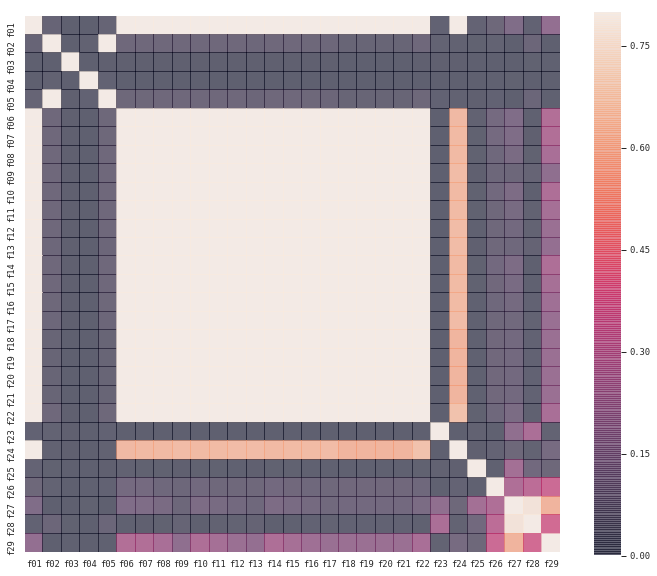

In [100]:
corr_matrix = features.drop(['Adj Close', 'Log Returns'], axis=1).corr(method='pearson', min_periods=1000)

#Plot Absolute Values
corr_matrix = np.abs(corr_matrix)
sns.set(context='paper', font='monospace')

f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix, vmax=0.8, square=True, alpha=0.6)

plt.show()

### Correlation between the Features and the Adjusted Close Price (Target Variable)

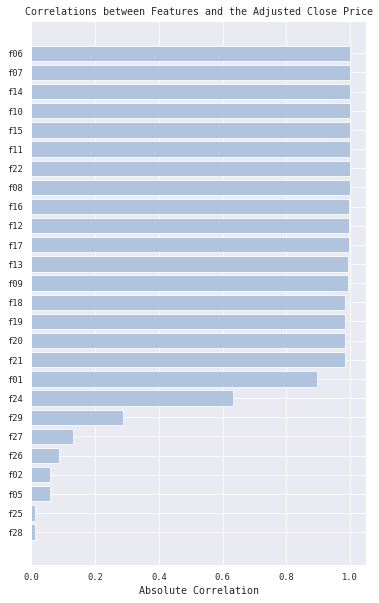

In [101]:
corr_target = features.corr(method='pearson', min_periods=1000)['Adj Close'].reset_index()[:-2]
corr_target.columns = ['Feature', 'Abs_corr']
corr_target['Abs_corr'] = np.abs(corr_target['Abs_corr'])
corr_target = corr_target.sort_values(by = 'Abs_corr', ascending = True).loc[corr_target['Abs_corr'] >0.01]

ind = np.arange(corr_target.shape[0])
width = 0.9

fig, ax = plt.subplots(figsize = (6, 10))
rects = ax.barh(ind, corr_target.Abs_corr.values, color = 'lightsteelblue')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.Feature.values, rotation = 'horizontal')
ax.set_xlabel('Absolute Correlation', fontsize=10)
ax.set_title('Correlations between Features and the Adjusted Close Price', fontsize=10)
plt.show()

### Correlation Among the Selected Features

In [102]:
corr_target_index = list(corr_target['Feature'])
corr_target_index.sort()
corr_target_index.append('Adj Close')

In [103]:
features_selected = features[corr_target_index]

In [104]:
corr_target['Abs_corr'].describe()

count    26.000000
mean      0.733603
std       0.406105
min       0.011248
25%       0.373580
50%       0.987207
75%       0.998539
max       0.999780
Name: Abs_corr, dtype: float64

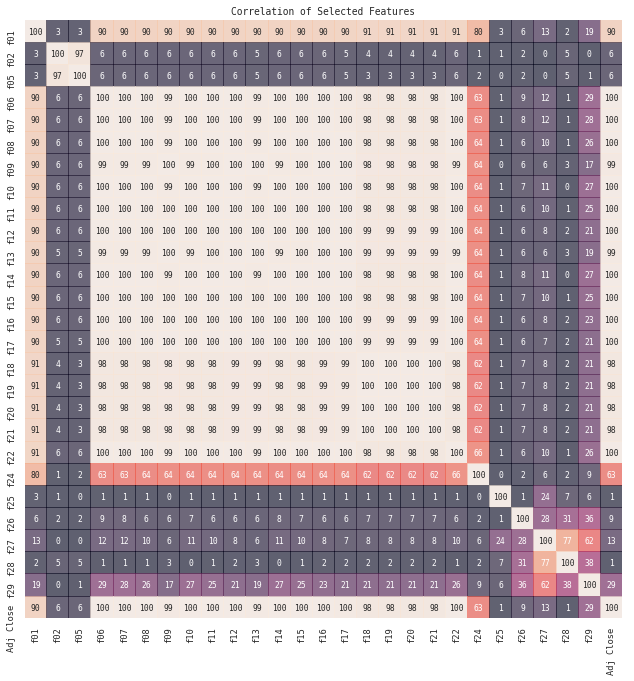

In [105]:
corr_selected_features = features_selected.corr(method='pearson', min_periods=1000)
corr_selected_features = np.abs(corr_selected_features) * 100

f, ax = plt.subplots(figsize=(11,11))
sns.heatmap(corr_selected_features, cbar=False, annot=True, square=True,
            fmt='.0f', annot_kws={'size':8}, alpha=0.6)
plt.title('Correlation of Selected Features')
plt.show()


In [106]:
#Filter the Upper Part of the Correlation Matrix
corr_selected_features_upper = corr_selected_features.where(np.triu
                                     (np.ones(corr_selected_features.shape), 
                                      k=1).astype(np.bool))

In [107]:
#Get the Pairs of features with correlation greater than 99
highly_corr_features = corr_selected_features_upper[corr_selected_features_upper > 99].stack().index.tolist()

In [108]:
#Get a List of Highly Correlated Feature Pairs
highly_corr_features_list = []
for i, j in highly_corr_features:
    if j != 'Adj Close':
        highly_corr_features_list.append((i, j))

### Feature Selection with XGB

In [109]:
target_var = features['Adj Close'].values
feature_var = features.drop(['Adj Close', 'Log Returns'], axis=1)

In [110]:
xgb_params = {'eta': 0.05,
             'max_depth': 10,
             'subsample': 1.0,
             'colsample_bytree': 0.7,
             'objective': 'reg:squarederror',
             'eval_metric': 'rmse',
             }

In [111]:
model_train = xgb.DMatrix(feature_var, target_var, feature_names = feature_var.columns.values)
model = xgb.train(dict(xgb_params), model_train, num_boost_round=100)

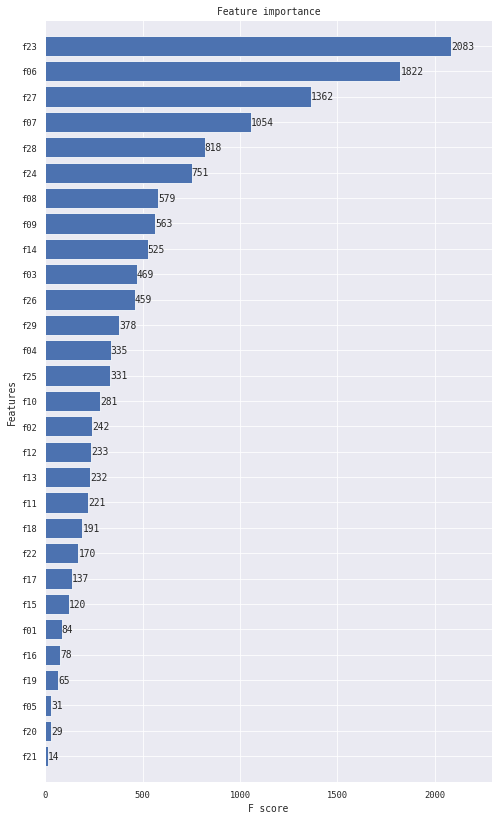

In [112]:
fig, ax = plt.subplots(figsize=(8,14))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

In [113]:
feature_importance = model.get_score(importance_type='weight')
tuples = sorted([(k, feature_importance[k]) for k in feature_importance], key=lambda x: x[1], reverse=True)
xgb_imp_f = [x[0] for x in tuples]

In [114]:
feature_importance_df = DataFrame(feature_importance.items(), columns=['Features', 'F-score'])
feature_importance_df.head()

,Features,F-score
0,f06,1822
1,f14,525
2,f23,2083
3,f11,221
4,f22,170


### Drop One of the Highly Correlated Features

In [115]:
#Features to Drop

features_to_drop = []
for i,j in highly_corr_features_list:
    if feature_importance[i] > feature_importance[j]:
        features_to_drop.append(j)
    else:
        features_to_drop.append(i)
        
features_to_drop_list = list(set(features_to_drop))


In [116]:
features_to_drop_list

['f15',
 'f22',
 'f21',
 'f10',
 'f14',
 'f12',
 'f09',
 'f20',
 'f13',
 'f08',
 'f17',
 'f19',
 'f07',
 'f11',
 'f16']

In [117]:
final_selected_features = features_selected.drop(features_to_drop_list, axis=1)

In [118]:
final_selected_features.head()

,f01,f02,f05,f06,f18,f24,f25,f26,f27,f28,f29,Adj Close
Date,,,,,,,,,,,,
2000-04-27,2000,4,2,3.750711,3.616805,0.743880,15.966752,-0.135652,52.139885,1.400010,-0.151654,3.918828
2000-04-28,2000,4,2,3.918828,3.619508,0.732966,15.369084,-0.448018,50.162714,3.872370,-0.126589,3.835737
2000-05-01,2000,5,2,3.835737,3.622239,0.722971,14.814107,-0.289178,50.351272,13.787168,-0.085150,3.843464
2000-05-02,2000,5,2,3.843464,3.622506,0.717220,14.924724,-0.325216,45.568981,3.569475,-0.113262,3.644432
2000-05-03,2000,5,2,3.644432,3.621732,0.714091,15.747989,0.064734,43.619713,2.849153,-0.166492,3.557475


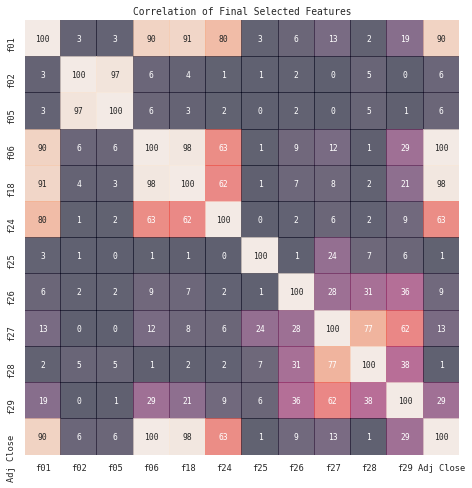

In [119]:
corr_final_selected_features = final_selected_features.corr(method='pearson', min_periods=1000)
corr_final_selected_features = np.abs(corr_final_selected_features) * 100

f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_final_selected_features, cbar=False, annot=True, square=True,
            fmt='.0f', annot_kws={'size':8}, alpha=0.6)
plt.title('Correlation of Final Selected Features')
plt.show()

### Dimentionality Reduction

In [120]:
#Standardize the features to be between 0 and 1
feature_variable = final_selected_features.drop(['Adj Close'], axis=1)
target_variable = final_selected_features['Adj Close']

In [121]:
target_variable.head()

Date
2000-04-27    3.918828
2000-04-28    3.835737
2000-05-01    3.843464
2000-05-02    3.644432
2000-05-03    3.557475
Name: Adj Close, dtype: float64

In [122]:
feature_variable.head()

,f01,f02,f05,f06,f18,f24,f25,f26,f27,f28,f29
Date,,,,,,,,,,,
2000-04-27,2000,4,2,3.750711,3.616805,0.743880,15.966752,-0.135652,52.139885,1.400010,-0.151654
2000-04-28,2000,4,2,3.918828,3.619508,0.732966,15.369084,-0.448018,50.162714,3.872370,-0.126589
2000-05-01,2000,5,2,3.835737,3.622239,0.722971,14.814107,-0.289178,50.351272,13.787168,-0.085150
2000-05-02,2000,5,2,3.843464,3.622506,0.717220,14.924724,-0.325216,45.568981,3.569475,-0.113262
2000-05-03,2000,5,2,3.644432,3.621732,0.714091,15.747989,0.064734,43.619713,2.849153,-0.166492


In [124]:
features_standardized = StandardScaler().fit_transform(feature_variable)


C:\Users\Musonda\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Musonda\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


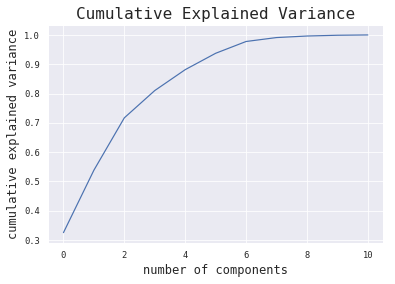

In [125]:
#Select the Number of Principal Components to Use

pca = PCA().fit(features_standardized)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance', fontsize=16)
plt.xlabel('number of components', fontsize=12)
plt.ylabel('cumulative explained variance', fontsize=12)
plt.show()

In [126]:
#fit a model with six components
model = PCA(n_components=6)
model = model.fit_transform(features_standardized)

### Scatter Plots of the Principal Components Against the Target Variable

In [127]:
pc_df = DataFrame(model, columns = ['PC1', 'PC2', 'PC3',
                                            'PC4', 'PC5', 'PC6'],
                 index = target_variable.index )

In [128]:
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
Date,,,,,,
2000-04-27,-2.201182,-0.406993,0.748464,-0.979175,0.219178,-0.237895
2000-04-28,-2.180405,-0.533947,0.740633,-1.128607,0.158544,-0.059831
2000-05-01,-2.076385,-1.090424,0.472267,-1.161830,0.680907,0.421950
2000-05-02,-2.245971,-0.261620,0.578814,-1.190457,0.119588,-0.101312
2000-05-03,-2.304053,-0.065409,0.606463,-1.050601,0.197517,-0.203896


In [129]:
engineered_df = pd.concat([pc_df, target_variable],axis = 1)

In [130]:
engineered_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Adj Close
Date,,,,,,,
2000-04-27,-2.201182,-0.406993,0.748464,-0.979175,0.219178,-0.237895,3.918828
2000-04-28,-2.180405,-0.533947,0.740633,-1.128607,0.158544,-0.059831,3.835737
2000-05-01,-2.076385,-1.090424,0.472267,-1.161830,0.680907,0.421950,3.843464
2000-05-02,-2.245971,-0.261620,0.578814,-1.190457,0.119588,-0.101312,3.644432
2000-05-03,-2.304053,-0.065409,0.606463,-1.050601,0.197517,-0.203896,3.557475


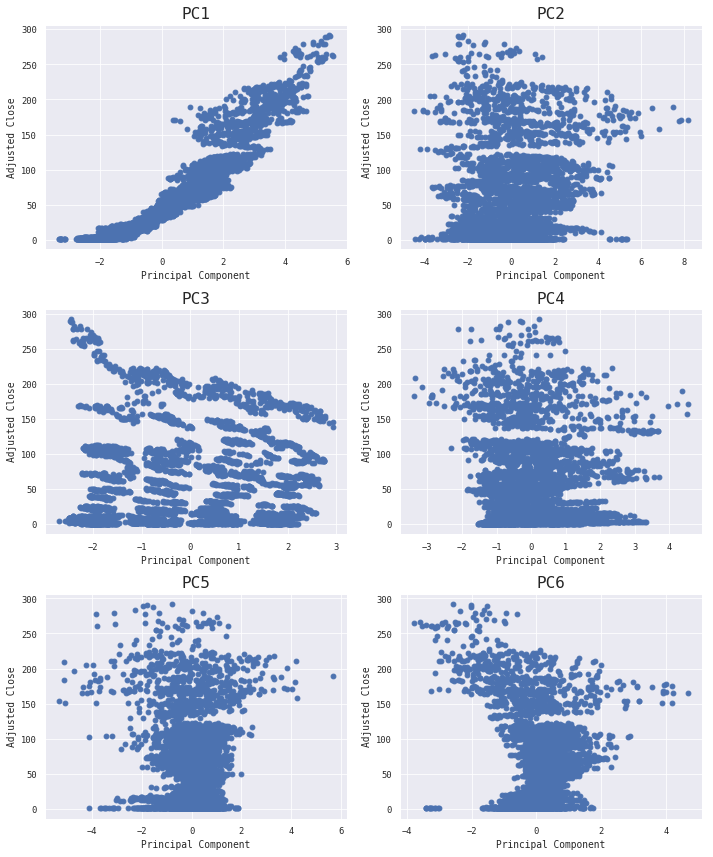

In [131]:
fig, axs = plt.subplots(3, 2, figsize=(10,12))


axs[0, 0].scatter(engineered_df['PC1'], engineered_df['Adj Close'], lw=1)
axs[0, 0].set_title('PC1', size=16)
axs[0, 1].scatter(engineered_df['PC2'], engineered_df['Adj Close'], lw=1)
axs[0, 1].set_title('PC2', size=16)
axs[1, 0].scatter(engineered_df['PC3'], engineered_df['Adj Close'], lw=1)
axs[1, 0].set_title('PC3', size=16)
axs[1, 1].scatter(engineered_df['PC4'], engineered_df['Adj Close'], lw=1)
axs[1, 1].set_title('PC4', size=16)
axs[2, 0].scatter(engineered_df['PC5'], engineered_df['Adj Close'], lw=1)
axs[2, 0].set_title('PC5', size=16)
axs[2, 1].scatter(engineered_df['PC6'], engineered_df['Adj Close'], lw=1)
axs[2, 1].set_title('PC6', size=16)

for ax in axs.flat:
    ax.set(xlabel='Principal Component', ylabel='Adjusted Close')

fig.tight_layout()
plt.show()